# TOEC

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chazeon/toec-paper-2022/blob/master/NaCl.ipynb)

In [1]:
import numpy
import pandas
import scipy
import itertools

In [2]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
# %config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams["figure.figsize"] = (4, 3)
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["xtick.minor.visible"] = True
rcParams["ytick.minor.visible"] = True
rcParams["xtick.top"] = True
rcParams["ytick.right"] = True
rcParams["font.sans-serif"] = ['Helvetica', 'TeX Gyre Heros', 'Arial', 'DejaVu Sans', 'Avant Garde', 'sans-serif']
rcParams["figure.dpi"] = 300
rcParams["legend.frameon"] = False

In [3]:
colors = rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# fields
system = "NaCl"

In [5]:
xi = 0.01

In [6]:
df = pandas.read_table(f"data/{system}/toec-zhao.txt", sep=r"\s+")
df

akey      energy                           fname  strain  volume
0     A3 -124.693956  toec/V153.0/A3/-0.03/elast.out   -0.03   153.0
1     A3 -124.722967   toec/V153.0/A3/0.02/elast.out    0.02   153.0
2     A3 -124.719470    toec/V153.0/A3/0.0/elast.out    0.00   153.0
3     A3 -124.714042  toec/V153.0/A3/-0.01/elast.out   -0.01   153.0
4     A3 -124.722337   toec/V153.0/A3/0.01/elast.out    0.01   153.0
..   ...         ...                             ...     ...     ...
667   A2 -124.720791   toec/V157.0/A2/0.03/elast.out    0.03   157.0
668   A2 -124.722092    toec/V157.0/A2/0.0/elast.out    0.00   157.0
669   A2 -124.710799  toec/V157.0/A2/-0.03/elast.out   -0.03   157.0
670   A2 -124.720014  toec/V157.0/A2/-0.01/elast.out   -0.01   157.0
671   A2 -124.722790   toec/V157.0/A2/0.01/elast.out    0.01   157.0

[672 rows x 5 columns]

In [7]:
from utils.static_eos import get_p_of_v_from_f
from utils.units import _from_ang3, _to_gpa, _to_ang3

volume      energy   pressure
0    105.0 -124.395323  38.002910
1    109.0 -124.459217  31.813671
2    113.0 -124.512650  26.566074
3    117.0 -124.557195  22.101900
4    121.0 -124.594165  18.292586
5    125.0 -124.624664  15.033082
6    129.0 -124.649618  12.237104
7    133.0 -124.669811   9.833425
8    137.0 -124.685908   7.762973
9    141.0 -124.698473   5.976537
10   145.0 -124.707990   4.432948
11   149.0 -124.714871   3.097631
12   153.0 -124.719470   1.941432
13   157.0 -124.722092   0.939688
14   161.0 -124.723000   0.071458
15   165.0 -124.722421  -0.681093

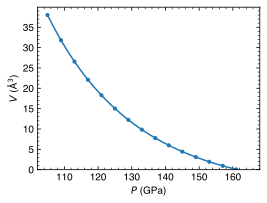

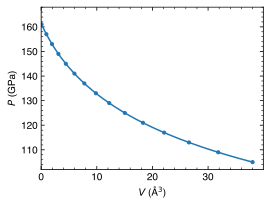

In [8]:
tmp = []

for volume in sorted(df["volume"].unique()):
    tmp.append({
        "volume": volume,
        "energy": numpy.average(df[(df["volume"] == volume) & (df["strain"] == 0.0)]["energy"].values)
    })
    
tmp = pandas.DataFrame(tmp)
tmp = tmp.sort_values(by="volume")

p_of_v = get_p_of_v_from_f(_from_ang3(tmp["volume"].values), tmp["energy"].values)

tmp["pressure"] = _to_gpa(p_of_v(_from_ang3(tmp["volume"].values)))
display(tmp)

#######################################################

plt.figure()

v_array = numpy.linspace(numpy.min(tmp["volume"].values), numpy.max(tmp["volume"].values), 500)
p_array = _to_gpa(p_of_v(_from_ang3(v_array)))

plt.scatter(tmp["volume"], tmp["pressure"], s=10)
plt.plot(v_array, p_array)
plt.xlabel("$P$ (GPa)")
plt.ylabel("$V$ (Å$^3$)")

plt.ylim(bottom=0)

plt.show()

#######################################################

plt.figure()

plt.scatter(tmp["pressure"], tmp["volume"], s=10)
plt.plot(p_array, v_array)
plt.ylabel("$P$ (GPa)")
plt.xlabel("$V$ (Å$^3$)")

plt.xlim(left=0)

plt.show()

## Thermodynamic EC

According to Zhao (2017), extracting polynomial fitting coef of $E$ vs. $\xi$

$$
E(\xi) / V_0 = M_1 \xi^1 + M_2 \xi^2 + M_3 \xi^3 + O(\xi^4)
$$

In [9]:
df2 = pandas.DataFrame()

for volume, akey in itertools.product(
    df["volume"].unique(),
    df["akey"].unique(),
):
    x, y = df[
        (df["volume"] == volume) &
        (df["akey"] == akey)
    ].loc[:, ["strain", "energy"]].sort_values(by="strain").T.values.tolist()
    
    x #*= (volume / v0) ** (1/3) # ?
    y /= _from_ang3(volume) # ?
    
    p = numpy.polyfit(x, y, deg=4)
    
    row = dict(
        volume= volume,
        akey= akey,
    )
    
    for i, a in enumerate(p[::-1]):
        row[f"M{i}"] = _to_gpa(a)

    df2 = df2.append(row, ignore_index=True)
        
df2[df2["akey"] == "A1"].sort_values(by="volume")

/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 =

/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 =

/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(row, ignore_index=True)
/var/folders/bt/gpgvfxtx557bzw0mp4c1fctr0000gn/T/ipykernel_54368/1876034406.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 =

volume akey           M0         M1          M2          M3           M4
70   105.0   A1 -2582.532627 -37.996658  224.688063 -856.378428  2555.766657
22   109.0   A1 -2489.038594 -31.812034  196.471829 -765.510732  2333.196711
46   113.0   A1 -2401.961812 -26.565782  172.118723 -684.827158  2075.233814
58   117.0   A1 -2320.673386 -22.100811  150.911417 -613.800717  1905.482833
88   121.0   A1 -2244.622950 -18.291533  132.459455 -549.972389  1753.779104
10   125.0   A1 -2173.326884 -15.031908  116.409808 -493.619986  1565.544693
52   129.0   A1 -2106.358580 -12.235684  102.295772 -444.048074  1472.194740
76   133.0   A1 -2043.340412  -9.832443   89.948293 -399.279044  1347.209789
28   137.0   A1 -1983.936964  -7.762231   79.125244 -360.218162  1211.442003
16   141.0   A1 -1927.849325  -5.975692   69.539357 -325.950182  1141.938288
82   145.0   A1 -1874.810353  -4.432401   61.149178 -294.825649  1002.240165
34   149.0   A1 -1824.580545  -3.097871   53.699917 -265.778621   919.917660
4    153.0   A1 -1776.944615  -1.941091   47.072442 -241.020746   858.089981
94   157.0   A1 -1731.708545  -0.938694   41.206046 -218.681463   783.634873
64   161.0   A1 -1688.697021  -0.069933   36.001948 -197.828306   707.750767
40   165.0   A1 -1647.751262   0.684269   31.369444 -179.454139   635.545890

### Plotting $T_{11}$

Strain (A1) (Zhao et al., 2007):

$$
\eta_{i j}=\left[\begin{array}{ccc}
\xi & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}\right]
$$

And
$$
M_1 = \sum_{i j} T_{i j} \eta_{i j}
$$

Therefore, $M_1 = T_{11}$.

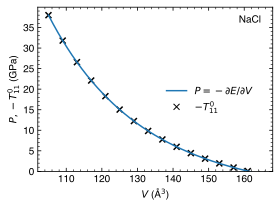

In [10]:
from matplotlib.lines import Line2D

plt.figure(figsize=(4,3))
line, = plt.plot(v_array, p_array, label="P")

for volume, akey in itertools.product(
    df["volume"].unique(),
    ["A1"]
):
    plt.scatter(
        volume,
        - df2[(df2["akey"] == akey) & (df2["volume"] == volume)]["M1"],
        c="k", marker="x")
    
plt.legend(*zip(
    (line, r"$P = -\partial E / \partial V$"),
    (Line2D([], [], ls="", marker="x", c="k"), "$-T^0_{11}$")),
    loc="lower right", bbox_to_anchor=(.95, 0.3)
    
)
plt.xlabel("$V$ (Å$^3$)")
plt.ylabel("$P, -T^0_{11}$ (GPa)")

plt.ylim(0)

plt.text(0.95, 0.95, system, ha='right', va='top', transform=plt.gca().transAxes)
plt.tight_layout()

plt.savefig(f"PxV-{system}.png")
plt.show()

In [11]:
from sympy.parsing.sympy_parser import parse_expr
from sympy.solvers.solveset import linear_eq_to_matrix
from sympy import symbols

In [12]:
coef = {
    "M2": {
        "A1": "c11",
        "A2": "2*c11 + 2*c12",
        "A3": "3*c11 + 6*c12", 
        "A4": "c11 + 4*c44", 
        "A5": "c11 + 4*c44", 
        "A6": "12*c44"
    },
    "M3": {
        "A1": "c111",
        "A2": "2*c111 + 6*c112",
        "A3": "3*c111 + 18*c112 + 6*c123", 
        "A4": "c111 + 12*c144", 
        "A5": "c111 + 12*c166", 
        "A6": "48*c456"
    }
}

symb = {
    "M2": symbols("c11 c12 c44"),
    "M3": symbols("c111 c112 c123 c144 c166 c456")
}

df3 = pandas.DataFrame([])

for volume in df["volume"].unique():
    for a_ in ["M2", "M3"]:
        
        b = df2[df2["volume"] == volume].sort_values(by="akey").loc[:, a_]
        if a_ == "M2":
            b *= 2
        elif a_ == "M3":
            b *= 6
        
        a = coef[a_].values()
        a = list(map(parse_expr, a))
        a = linear_eq_to_matrix(a, *symb[a_])[0]
        a = numpy.array(a).astype(numpy.float64)
        x, r, _, _ = numpy.linalg.lstsq(a, b, rcond=None)
        for key, val in zip(symb[a_], x):
            df3.loc[volume, str(key)] = val
            
# _to_gpa(numpy.array(a2) / _from_ang3(5.38 ** 3)) * 2)

df3.insert(0, "volume", df3.index)
df3.insert(0, "pressure", _to_gpa(p_of_v(_from_ang3(df3["volume"].values))))
df3 = df3.sort_values("pressure")
df3 = df3.sort_values("volume")
df3

pressure  volume         c11        c12        c44         c111  \
105.0  38.002910   105.0  449.357277  20.685497  49.996407 -5138.270566   
109.0  31.813671   109.0  393.001706  20.030232  44.452128 -4593.064394   
113.0  26.566074   113.0  344.196951  19.379601  39.681022 -4108.962946   
117.0  22.101900   117.0  301.814192  18.731557  35.572485 -3682.804303   
121.0  18.292586   121.0  264.935667  18.061123  31.997208 -3299.834332   
125.0  15.033082   125.0  232.785576  17.428174  28.902661 -2961.719915   
129.0  12.237104   129.0  204.631914  16.810935  26.203901 -2664.288441   
133.0   9.833425   133.0  179.947166  16.221518  23.830051 -2395.674262   
137.0   7.762973   137.0  158.265548  15.659700  21.751905 -2161.308971   
141.0   5.976537   141.0  139.095388  15.136562  19.913688 -1955.701090   
145.0   4.432948   145.0  122.263161  14.619092  18.288238 -1768.953893   
149.0   3.097631   149.0  107.349402  14.132402  16.861295 -1594.671727   
153.0   1.941432   153.0   94.119270  13.674502  15.587885 -1446.124475   
157.0   0.939688   157.0   82.390392  13.239323  14.455297 -1312.088778   
161.0   0.071458   161.0   71.991564  12.807173  13.444981 -1186.969837   
165.0  -0.681093   165.0   62.706107  12.409723  12.543604 -1076.724833   

            c112       c123       c144        c166       c456  
105.0 -64.012125  59.975324  34.889492 -285.171133  13.191688  
109.0 -62.774102  54.441257  32.220336 -254.707308  14.235278  
113.0 -62.695444  51.978274  30.008076 -228.007790  14.870073  
117.0 -60.552010  46.578469  27.688312 -204.686495  15.396772  
121.0 -60.051580  44.037825  26.022351 -184.658609  15.700986  
125.0 -59.583178  43.113031  24.463012 -167.123548  15.864627  
129.0 -57.735637  40.837402  23.000376 -151.380025  15.959445  
133.0 -56.909784  39.153931  22.080996 -137.949316  15.991649  
137.0 -54.806199  37.126780  20.773317 -125.523875  15.911477  
141.0 -51.963072  34.355750  20.398727 -114.018147  15.889535  
145.0 -49.276808  30.484805  19.627203 -104.191217  15.712203  
149.0 -49.579498  31.698368  18.490714  -96.111076  15.595191  
153.0 -47.491773  30.473887  17.809415  -88.255544  15.434826  
157.0 -45.124746  27.383393  17.548512  -80.800294  15.234423  
161.0 -44.755833  28.207458  16.736425  -74.843789  14.996965  
165.0 -42.936880  26.055713  16.147203  -69.359575  14.725148

In [13]:
delta = lambda i,j: int(i == j)

Eulierian strain

$$ x = \frac{1}{2} \left[\left(\frac{a_0}{a}\right)^{2} - 1\right] = \frac{1}{2} \left[\left(\frac{V_0}{V}\right)^{2/3} - 1\right] $$

In [14]:
v0 = v_array[numpy.argmin(numpy.abs(p_array))]
x_array = 1/2 * ((v0 / v_array) ** 2/3 - 1)
x_of_v = lambda v: 1/2 * ((v0 / v) ** 2/3 - 1)

In [15]:
df4 = []
for _, row in df3.iterrows():
    
    _row = {
        "pressure": row["pressure"],
        "volume": row["volume"]
    }
    for ij in ["11", "12", "44"]:
        i,j,k,l = list("".join(({"1": "11", "2": "22", "4": "23"}[i] for i in ij)))
        _row[f"c{ij}"] = row[f"c{ij}"] + row["pressure"] * (delta(i,j) * delta(k,l) - delta(i,l) * delta(k,j) - delta(i,k) * delta(j,l))
    df4.append(_row)
    
df4 = pandas.DataFrame(df4)
display(df4)

pressure  volume         c11        c12        c44
0   38.002910   105.0  411.354367  58.688407  11.993496
1   31.813671   109.0  361.188035  51.843903  12.638457
2   26.566074   113.0  317.630876  45.945675  13.114948
3   22.101900   117.0  279.712291  40.833457  13.470585
4   18.292586   121.0  246.643082  36.353709  13.704622
5   15.033082   125.0  217.752494  32.461256  13.869580
6   12.237104   129.0  192.394810  29.048039  13.966797
7    9.833425   133.0  170.113741  26.054943  13.996626
8    7.762973   137.0  150.502575  23.422673  13.988932
9    5.976537   141.0  133.118852  21.113098  13.937151
10   4.432948   145.0  117.830213  19.052040  13.855290
11   3.097631   149.0  104.251772  17.230033  13.763664
12   1.941432   153.0   92.177838  15.615934  13.646453
13   0.939688   157.0   81.450704  14.179012  13.515608
14   0.071458   161.0   71.920105  12.878632  13.373523
15  -0.681093   165.0   63.387200  11.728630  13.224697

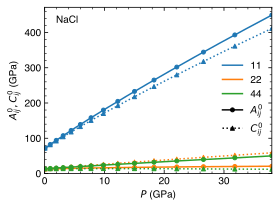

In [16]:
plt.figure(figsize=(4,3))

for key in ["11", "12", "44"]:
    
    line, = plt.plot(df3["pressure"], df3[f"c{key}"], label=key, marker="o", markersize=4, ls="")
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, c_array, color=line.get_color())
    
    line, = plt.plot(df4["pressure"], df4[f"c{key}"], label=key, marker="^", markersize=4, ls="", color=line.get_color())
    
    p = numpy.polyfit(x_of_v(df4["volume"]), df4[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, c_array, color=line.get_color(), ls="dotted")

plt.ylabel("$A^0_{ij}, C^0_{ij}$ (GPa)")
plt.xlabel("$P$ (GPa)")

plt.xlim(left=0, right=df3["pressure"].max())
plt.ylim(bottom=0)
plt.text(0.05, 0.95, system, ha='left', va='top', transform=plt.gca().transAxes)

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:3]],
    Line2D([], [], color="k", ls="-",      marker="o", markersize=4),
    Line2D([], [], color="k", ls="dotted", marker="^", markersize=4),
], ["11", "22", "44", "$A^0_{ij}$", "$C^0_{ij}$"], loc="center right", bbox_to_anchor=[1, .45])

plt.tight_layout()
plt.savefig(f"SOECxP-{system}.png", dpi=300)
plt.show()

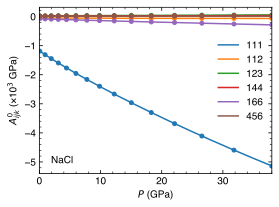

In [17]:
for key in ["111", "112", "123", "144", "166", "456"]:
    
    line, = plt.plot(df3["pressure"], df3[f"c{key}"] / 1e3, label=key[1:], marker="o", markersize=4, ls="")
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, c_array / 1e3, color=line.get_color())

plt.xlabel("$P$ (GPa)")
plt.ylabel(r"$A^0_{ijk}$ (×10$^3$ GPa)")

plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.xlim(left=0, right=df3["pressure"].max())
# plt.legend(bbox_to_anchor=[1, .85], loc="upper right")

plt.legend([
    *[Line2D([], [], color=c) for c in colors],
], ["111", "112", "123", "144", "166", "456"], loc="upper right", bbox_to_anchor=[1, .85])

plt.tight_layout()
plt.savefig(f"TOECxP-{system}.png", dpi=300)

plt.show()

In [18]:
from utils.voigttools import iternd

def bloat(d: dict, ndim=2) -> numpy.ndarray:
    '''Python dict to 6x6 or 6x6x6 matrix
    '''
    
    c6 = numpy.zeros([6] * ndim)
    for ij in iternd(ndim, 6):
        key = ("%d" * ndim) % tuple(sorted(ij))
        c6[tuple(i-1 for i in ij)] = d.get(f"c{key}", 0)
    
    return c6

def flatten(c6: numpy.ndarray, ndim=2, proto: dict = None) -> dict:
    '''Python dict to 6x6 or 6x6x6 matrix
    '''
    
    d = proto if proto is not None else {}
    for ij in iternd(ndim, 6):
        key = ("%d" * ndim) % tuple(sorted(ij))
        d[f"c{key}"] = c6[tuple(i-1 for i in ij)] 
        
    return d

In [19]:
# import re

from utils.brugger import load_table

def fill(data, system="C", ndim=2):
    
    d = load_table({
        2: "data/soec.yaml",
        3: "data/toec.yaml"
    }[ndim], system)


    lhs = []
    rhs = []

    for k, v in data.items():
        c = numpy.zeros(len(d[0]))
#         res = re.search(r"^c(\d\d)$", k)
#         if res == None: continue
        if not k.startswith("c"): continue
        if len(k) != ndim + 1: continue

        c[d[0].index(k[1:])] = 1

        lhs.append(c)
        rhs.append(v)
    
    relations = d[2]
    lhs = numpy.array([*lhs, *relations])
    rhs = numpy.array([*rhs, *numpy.zeros(relations.shape[0])])
    
    solution = dict([(k, v) for k, v in zip(
        [f"c{key}" for key in d[0]],
        numpy.linalg.lstsq(lhs, rhs, rcond=None)[0]
    ) if numpy.abs(v) > .1])
    
    return {**data, **solution}

In [20]:
c_ij = lambda row: bloat(fill(row, ndim=2, system="C"), ndim=2)
c_ijk = lambda row: bloat(fill(row, ndim=3, system="C I"), ndim=3)

# c_ij(df3.iloc[1])

In [21]:
from utils.voigttools import _6to3, _3to6

In [22]:
import re

volumes = df3["volume"]

df3_ = df3.copy()
for key, col in df3_.iteritems():
    if re.search(r"^c\d{2,3}$", key) is None: continue
    x = x_of_v(volumes)
    p = numpy.polyfit(x, col, 3)
    df3_[key] = numpy.polyval(p, x)
    
df4_ = df4.copy()
for key, col in df4_.iteritems():
    if re.search(r"^c\d{2,3}$", key) is None: continue
    x = x_of_v(volumes)
    p = numpy.polyfit(x, col, 3)
    df4_[key] = numpy.polyval(p, x)

# display(df3)
# display(df3_)
        
    

$$ \frac{\partial A_{ijkl}}{\partial P} = - A_{ijklmn} (C^{-1})_{mnpq} \delta_{mn} - \frac{1}{3} A_{ijkl} (C^{-1})_{mnpq} \delta_{mn} \delta_{pq} $$

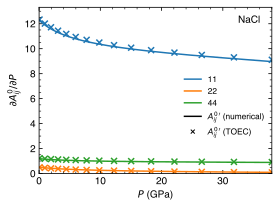

In [23]:
for key in ["11", "12", "44"]:
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(p_array))
    
#     p = numpy.polyfit(x_of_v(df4["volume"]), df4[f"c{key}"], 3)
#     c_array = numpy.polyval(p, x_array)
#     line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(p_array), color=line.get_color(), ls="dotted")
    
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    aij_p = \
        - numpy.einsum("ijklmn,mnpq,pq->ijkl", _6to3(aijk),  _6to3(numpy.linalg.inv(cij)), numpy.eye(3)) \
        - 1/3 * numpy.einsum("ijkl,mnpq,mn,pq->ijkl", _6to3(aij), _6to3(numpy.linalg.inv(cij)), numpy.eye(3), numpy.eye(3))
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[3,3]], c=colors[2], marker="x")
        
    
    
plt.ylabel(r"$\partial A^0_{ij} / \partial P$")
plt.xlabel("$P$ (GPa)")

plt.xlim(left=0, right=df3["pressure"].max())
plt.ylim(bottom=0)
plt.text(0.95, 0.95, system, ha='right', va='top', transform=plt.gca().transAxes)

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:3]],
    Line2D([], [], color="k", ls="-",      marker="", markersize=4),
#     Line2D([], [], color="k", ls="dotted", marker="", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=4),
], [
    "11", "22", "44",
    "$A^{0\,\prime}_{ij}$ (numerical)",
#     "$C_{ij}'$"
     r"$A^{0\,\prime}_{ij}$ (TOEC)"
], loc="center right", bbox_to_anchor=[1, .4], fontsize="small")

plt.tight_layout()

plt.savefig(f"dSOECdPxP-{system}.png", dpi=300)
plt.show()

Validating change in stress.

$$T^\text{SK1} = T^\text{SK} - T^\circ = J F F T^\text{L} - T^\circ = A_{ijkl} e_{ij}$$

$$T^\text{L1} = T^\text{L} - T^\circ = C_{ijkl} e_{ij}$$

The following example use $e_{11} = e_{22} = e_{33} = 0.001$.

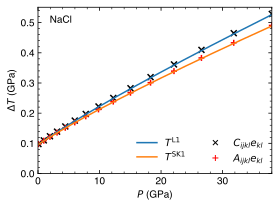

In [24]:
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    x = 0.001
    
    plt.scatter([df4.iloc[i]["pressure"]], [(cij @ numpy.array([1,1,1,0,0,0]) * x)[0]], marker="x", c="k")
    plt.scatter([df4.iloc[i]["pressure"]], [(aij @ numpy.array([1,1,1,0,0,0]) * x)[0]], marker="+", c="r")
    
plt.plot(p_array, -_to_gpa(p_of_v(_from_ang3(v_array) * (1+x)**3) - p_of_v(_from_ang3(v_array))))
plt.plot(p_array, -_to_gpa(p_of_v(_from_ang3(v_array) * (1+x)**3) * (1+x) - p_of_v(_from_ang3(v_array))))

plt.xlim(left=0, right=df3["pressure"].max())
plt.ylim(bottom=0)

plt.legend([
    Line2D([], [], color=colors[0]),
    Line2D([], [], color=colors[1]),
    Line2D([], [], color="k", ls="", marker="x", markersize=5),
    Line2D([], [], color="r", ls="", marker="+", markersize=6),
], [
    r"$T^\mathrm{L1}$",
    r"$T^\mathrm{SK1}$",
    "$C_{ijkl} e_{kl}$",
    "$A_{ijkl} e_{kl}$"
],
    loc="lower right", ncol=2)

plt.ylabel(r"$\Delta T$ (GPa)")
plt.xlabel("$P$ (GPa)")
plt.text(0.05, 0.95, system, ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()

plt.savefig(f"dTxP-{system}.png")
plt.show()

In [25]:
from utils.voigttools import _3to6, _6to3, voigt
from numpy.linalg import det, inv

import pandas

def get_stress_tensor(fname) -> numpy.ndarray:
    out = sh.grep("total   stress", "-A", 3, fname)
    out = sh.tail(out, "-3")
    out = sh.cut(out, "-c-40")
    tensor = out.stdout.decode()
    return numpy.loadtxt(io.StringIO(tensor))

strain_by = {
    "e1": [1, 0, 0, 0, 0, 0],
    "e2": [0, 1, 0, 0, 0, 0],
    "e3": [0, 0, 1, 0, 0, 0],
    "e4": [0, 0, 0, 1, 0, 0],
    "e5": [0, 0, 0, 0, 1, 0],
    "e6": [0, 0, 0, 0, 0, 1],
}

def from_eta(eta: numpy.ndarray) -> numpy.ndarray:
    evals, evecs = numpy.linalg.eig(2 * eta + numpy.eye(3))
    F = numpy.linalg.inv(evecs.T) @ numpy.diag(evals ** (1/2)) @ evecs.T
    return F

def to_eta(F: numpy.ndarray) -> numpy.ndarray:
    eta = 1/2 * (F.T @ F - numpy.eye(3))
    return eta

def make_strain(akey: str, xi: float):
    eta = _6to3(numpy.array(strain_by[akey]))
    eta *= xi
    F = from_eta(eta)
    return F

In [26]:
F = make_strain("e3", 0.01)
display(F)
display(to_eta(F))
J = det(F)
display(J)

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.00995049]])

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01]])

1.0099504938362078

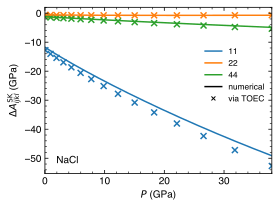

In [27]:
eta = numpy.eye(3) * xi
F = from_eta(eta)
J = det(F)

for key in ["11", "12", "44"]:
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array0 = numpy.polyval(p, x_array)
    c_array1 = numpy.polyval(p, x_of_v(v_array *J))
    plt.plot(p_array, c_array1 / (1 + xi) - c_array0)
    
                
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    daij = numpy.einsum("ijklmn,mn->ijkl", _6to3(aijk), eta)
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[3,3]], c=colors[2], marker="x")
    
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[2,2]], c=colors[3], marker="x")
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,2]], c=colors[4], marker="x")
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[5,5]], c=colors[5], marker="x")
    
plt.xlim(left=0, right=df3["pressure"].max())
# plt.ylim(bottom=0)
plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.tight_layout()
plt.ylabel(r"$\Delta A^\mathrm{SK}_{ijkl}$ (GPa)")
plt.xlabel("$P$ (GPa)")

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:3]],
    Line2D([], [], color="k", ls="-",      marker="", markersize=4),
#     Line2D([], [], color="k", ls="dotted", marker="", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=4),
], [
    "11", "22", "44",
    "numerical",
#     "$C_{ij}'$"
     r"via TOEC"
], loc="upper right", bbox_to_anchor=[1, .8], fontsize="small")

plt.tight_layout()
plt.savefig(f"dSOECxP-hs-x{xi}-aijk-{system}.png", dpi=300)
plt.show()

In [28]:
from scipy.interpolate import InterpolatedUnivariateSpline

df5 = df4.copy() # derivative

for key in ["11", "12", "44"]:
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    df5[f"c{key}"] = InterpolatedUnivariateSpline(v_array, numpy.gradient(c_array) / numpy.gradient(p_array))(df3["volume"])
    
display(df5)

pressure  volume        c11       c12       c44
0   38.002910   105.0   8.971020  0.094633  0.887591
1   31.813671   109.0   9.198085  0.115528  0.901709
2   26.566074   113.0   9.407036  0.137236  0.915679
3   22.101900   117.0   9.602330  0.159590  0.929763
4   18.292586   121.0   9.790534  0.182741  0.944360
5   15.033082   125.0   9.977084  0.206846  0.959814
6   12.237104   129.0  10.166619  0.232074  0.976432
7    9.833425   133.0  10.363240  0.258606  0.994501
8    7.762973   137.0  10.570713  0.286645  1.014301
9    5.976537   141.0  10.792640  0.316413  1.036118
10   4.432948   145.0  11.032608  0.348167  1.060255
11   3.097631   149.0  11.294332  0.382195  1.087043
12   1.941432   153.0  11.581795  0.418836  1.116852
13   0.939688   157.0  11.899400  0.458482  1.150109
14   0.071458   161.0  12.252143  0.501600  1.187308
15  -0.681093   165.0  12.639581  0.548003  1.228374

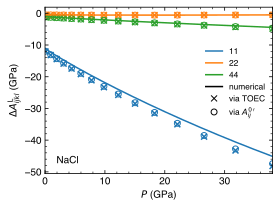

In [29]:
eta = numpy.eye(3) * xi
F = from_eta(eta)
J = det(F)

for key in ["11", "12", "44"]:
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array0 = numpy.polyval(p, x_array)
    c_array1 = numpy.polyval(p, x_of_v(v_array *J))
    plt.plot(p_array, c_array1 - c_array0)
    
                
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    cijk = numpy.copy(aijk)
    cijk -=       _3to6(numpy.einsum("ijkl,mn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("njkl,im->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("inkl,jm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijnl,km->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkn,lm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("mjkl,in->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("imkl,jn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijml,kn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkm,ln->ijklmn", _6to3(aij), numpy.eye(3)))
    
    daij = numpy.einsum("ijklmn,mn->ijkl", _6to3(cijk), eta)
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[3,3]], c=colors[2], marker="x")
    
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[2,2]], c=colors[3], marker="x")
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,2]], c=colors[4], marker="x")
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[5,5]], c=colors[5], marker="x")


    # pressure derivatives
    
    tij = numpy.einsum("ijkl,kl->ij", _6to3(cij), eta)
    
    p = -1/3 * numpy.sum(numpy.diag(tij))
    t = tij + p * numpy.eye(3)
    
    aij_p = c_ij(df5.iloc[i])
    
    daij = _6to3(aij_p * p)
    daij -= 1/4 * numpy.einsum("mjkl,im->ijkl", _6to3(aij_p), t)
    daij -= 1/4 * numpy.einsum("imkl,jm->ijkl", _6to3(aij_p), t)
    daij -= 1/4 * numpy.einsum("ijml,km->ijkl", _6to3(aij_p), t)
    daij -= 1/4 * numpy.einsum("ijkm,lm->ijkl", _6to3(aij_p), t)
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,0]], ec=colors[0], marker="o", c="none")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,1]], ec=colors[1], marker="o", c="none")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[3,3]], ec=colors[2], marker="o", c="none")
    
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[2,2]], ec=colors[3], marker="o", c="none")
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,2]], ec=colors[4], marker="o", c="none")
#     plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[5,5]], ec=colors[5], marker="o", c="none")

    
plt.xlim(left=0, right=df3["pressure"].max())
# plt.ylim(bottom=0)
plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.tight_layout()
plt.ylabel(r"$\Delta A^\mathrm{L}_{ijkl}$ (GPa)")
plt.xlabel("$P$ (GPa)")

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:3]],
    Line2D([], [], color="k", ls="-",      marker="", markersize=4),
#     Line2D([], [], color="k", ls="dotted", marker="", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=6),
    Line2D([], [], color="none", ls="", marker="o", markersize=6, mec="k"),
], [
    "11", "22", "44",
    "numerical",
#     "$C_{ij}'$"
     r"via TOEC",
    r"via $A^{0\,\prime}_{ij}$"
], loc="upper right", bbox_to_anchor=[1, .8], fontsize="small")

plt.tight_layout()
plt.savefig(f"dSOECxP-hs-x{xi}-cijk-{system}.png", dpi=300)
plt.show()

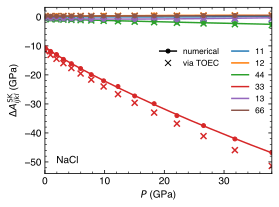

In [30]:
F = make_strain("e3", xi)

for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    daij = numpy.einsum("ijklmn,mn->ijkl", _6to3(aijk), to_eta(F))
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[3,3]], c=colors[2], marker="x")
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[2,2]], c=colors[3], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,2]], c=colors[4], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[5,5]], c=colors[5], marker="x")
    
    
###

def invert(C):
    F = make_strain("e3", xi)
    J = det(F)
    C = J * numpy.einsum("ir,js,kp,lq,rspq->ijkl", inv(F), inv(F), inv(F), inv(F), C)
    return C

tmp1 = pandas.read_table(f"data/{system}/elast-e33-x{xi}.dat", sep=r"\s+")
tmp1 = tmp1.sort_values(by="V")
if (xi == 0.01) and (system == "NaCl"):
    tmp1["V"] = _to_ang3(tmp1["V"].values)
tmp1.index = tmp1["V"]
tmp1 = tmp1.apply(lambda row: flatten(_3to6(invert(_6to3(bloat(row)))), proto=row), axis=1)

tmp0 = df3_.apply(lambda row: flatten(c_ij(row), proto=row), axis=1)

for i, key in enumerate(["11", "12", "44", "33", "13", "66"]):
    
    p_array1 = _to_gpa(p_of_v(_from_ang3(tmp1["V"].values)))
    
    x_array0 = x_of_v(tmp0["volume"])
    x_array1 = x_of_v(tmp1["V"])
    
    p = numpy.polyfit(x_array0, tmp0[f"c{key}"], 3)
    c_array0 = numpy.polyval(p, x_array1)
    
    p = numpy.polyfit(x_array1, tmp1[f"c{key}"], 3)
    c_array1 = tmp1[f"c{key}"]
    
    plt.plot(
        p_array1,
        c_array1 - c_array0,
        markersize=4, marker="o", ls="", c=colors[i])

    p = numpy.polyfit(x_of_v(tmp0["volume"]), tmp0[f"c{key}"], 3)
    c_array0 = numpy.polyval(p, x_array)
    
    p = numpy.polyfit(x_of_v(tmp1["V"]), tmp1[f"c{key}"], 3)
    c_array1 = numpy.polyval(p, x_array)
    
    plt.plot(p_array, c_array1 - c_array0, c=colors[i])
    
###
    
    
plt.xlim(left=0, right=df3["pressure"].max())
# plt.ylim(bottom=0)
plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

leg1 = plt.legend([
    *[Line2D([], [], color=c) for c in colors[:6]],
], [
    "11", "12", "44", "33", "13", "66",
], loc="upper right", bbox_to_anchor=[1, .8], fontsize="small")

leg2 = plt.legend([
    Line2D([], [], color="k", ls="-", marker="o", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=6),
#     Line2D([], [], color="none", ls="", marker="o", markersize=6, mec="k"),
], [
    r"numerical",
    r"via TOEC",
#     r"$A_{ij}'$",
], loc="upper right", bbox_to_anchor=[.8, .8], fontsize="small")


plt.gca().add_artist(leg1)

plt.ylabel(r"$\Delta A_{ijkl}^\mathrm{SK}$ (GPa)")
plt.xlabel("$P$ (GPa)")

plt.tight_layout()
plt.savefig(f"dSOECxP-e33-x{xi}-aijk-{system}.png", dpi=300)
plt.show()

pressure  volume         c11        c12        c44         c111  \
105.0  38.002910   105.0  449.286120  20.684931  49.991648 -5138.603660   
109.0  31.813671   109.0  393.077137  20.037577  44.456026 -4593.249080   
113.0  26.566074   113.0  344.268286  19.376171  39.688511 -4109.058462   
117.0  22.101900   117.0  301.845531  18.715223  35.570280 -3679.962544   
121.0  18.292586   121.0  264.916782  18.064629  32.001664 -3299.896074   
125.0  15.033082   125.0  232.708482  17.430990  28.899253 -2963.136598   
129.0  12.237104   129.0  204.555694  16.818559  26.193294 -2664.458478   
133.0   9.833425   133.0  179.889796  16.229916  23.825409 -2399.183515   
137.0   7.762973   137.0  158.225898  15.666452  21.746674 -2163.175566   
141.0   5.976537   141.0  139.151012  15.128713  19.916000 -1952.806625   
145.0   4.432948   145.0  122.313443  14.616659  18.298801 -1764.910151   
149.0   3.097631   149.0  107.413493  14.129842  16.865883 -1596.730517   
153.0   1.941432   153.0   94.195473  13.667542  15.592535 -1445.873414   
157.0   0.939688   157.0   82.440897  13.228860  14.457782 -1310.259641   
161.0   0.071458   161.0   71.962726  12.812788  13.443763 -1188.083358   
165.0  -0.681093   165.0   62.600514  12.418263  12.535229 -1077.775079   

            c112       c123       c144        c166  ...  c26         c33  c34  \
105.0 -63.695405  59.750603  34.985884 -285.139675  ...  0.0  449.286120  0.0   
109.0 -63.188790  54.927865  32.159699 -254.623859  ...  0.0  393.077137  0.0   
113.0 -62.429833  51.009404  29.782266 -228.093484  ...  0.0  344.268286  0.0   
117.0 -61.441287  47.730518  27.760982 -204.959099  ...  0.0  301.845531  0.0   
121.0 -60.256601  44.912383  26.025875 -184.721765  ...  0.0  264.916782  0.0   
125.0 -58.912059  42.433111  24.523378 -166.960559  ...  0.0  232.708482  0.0   
129.0 -57.442669  40.208882  23.211971 -151.320804  ...  0.0  204.555694  0.0   
133.0 -55.880184  38.181531  22.059100 -137.503584  ...  0.0  179.889796  0.0   
137.0 -54.252331  36.310295  21.038962 -125.256690  ...  0.0  158.225898  0.0   
141.0 -52.582701  34.566294  20.130898 -114.366934  ...  0.0  139.151012  0.0   
145.0 -50.890975  32.928806  19.318205 -104.653712  ...  0.0  122.313443  0.0   
149.0 -49.193309  31.382741  18.587261  -95.963634  ...  0.0  107.413493  0.0   
153.0 -47.502775  29.916918  17.926859  -88.166068  ...  0.0   94.195473  0.0   
157.0 -45.829797  28.522881  17.327710  -81.149444  ...  0.0   82.440897  0.0   
161.0 -44.182564  27.194089  16.782054  -74.818198  ...  0.0   71.962726  0.0   
165.0 -42.567391  25.925348  16.283364  -69.090233  ...  0.0   62.600514  0.0   

       c35  c36  c45  c46        c55  c56        c66  
105.0  0.0  0.0  0.0  0.0  49.991648  0.0  49.991648  
109.0  0.0  0.0  0.0  0.0  44.456026  0.0  44.456026  
113.0  0.0  0.0  0.0  0.0  39.688511  0.0  39.688511  
117.0  0.0  0.0  0.0  0.0  35.570280  0.0  35.570280  
121.0  0.0  0.0  0.0  0.0  32.001664  0.0  32.001664  
125.0  0.0  0.0  0.0  0.0  28.899253  0.0  28.899253  
129.0  0.0  0.0  0.0  0.0  26.193294  0.0  26.193294  
133.0  0.0  0.0  0.0  0.0  23.825409  0.0  23.825409  
137.0  0.0  0.0  0.0  0.0  21.746674  0.0  21.746674  
141.0  0.0  0.0  0.0  0.0  19.916000  0.0  19.916000  
145.0  0.0  0.0  0.0  0.0  18.298801  0.0  18.298801  
149.0  0.0  0.0  0.0  0.0  16.865883  0.0  16.865883  
153.0  0.0  0.0  0.0  0.0  15.592535  0.0  15.592535  
157.0  0.0  0.0  0.0  0.0  14.457782  0.0  14.457782  
161.0  0.0  0.0  0.0  0.0  13.443763  0.0  13.443763  
165.0  0.0  0.0  0.0  0.0  12.535229  0.0  12.535229  

[16 rows x 29 columns]

P           V       c11       c22       c33      c12  \
V                                                                       
105.000000  379.97  105.000000  445.0380  445.3010  414.6300  21.0400   
109.000000  318.10  109.000000  389.4470  389.3370  361.5800  20.3326   
113.000000  265.62  113.000000  340.8640  340.9010  316.0530  19.6112   
117.000001  220.96  117.000001  298.6860  299.0350  275.8750  19.0733   
120.999999  182.87  120.999999  262.3670  262.6480  242.0840  18.5688   
125.000000  150.25  125.000000  230.2660  230.4510  211.6460  17.6066   
129.000000  122.29  129.000000  202.5620  202.5240  186.0140  16.9497   
133.000000   98.38  133.000000  178.3550  178.3110  162.6140  16.5903   
137.000001   77.58  137.000001  156.8660  156.4100  142.4870  15.6192   
140.999999   59.70  140.999999  137.8730  137.6580  125.0040  15.2513   
145.000000   44.32  145.000000  120.9960  120.9880  109.3800  14.7736   
149.000000   30.97  149.000000  106.2400  106.2180   95.5677  14.2875   
153.000000   19.39  153.000000   93.0377   93.2348   83.6680  13.9503   
156.999999    9.38  156.999999   81.5460   81.4031   72.6719  13.3079   
160.999999    0.70  160.999999   71.2440   71.1724   63.1340  13.0071   
165.000000   -6.84  165.000000   61.8324   61.9864   54.7088  12.6551   

                c13      c23      c44      c55      c66       c14  \
V                                                                   
105.000000  20.6156  20.6156  47.8849  47.8936  49.9600  0.000000   
109.000000  19.6440  19.6440  42.5784  42.5783  44.4316  0.036769   
113.000000  19.1167  19.1167  38.0085  38.0084  39.6818  0.000000   
117.000001  17.8601  17.8601  34.0634  34.0628  35.5793 -0.202229   
120.999999  17.7835  17.7835  30.6498  30.6475  32.0229  0.014708   
125.000000  16.6682  16.6682  27.6749  27.6745  28.9355  0.055153   
129.000000  16.5818  16.5818  25.0867  25.0862  26.2360  0.018384   
133.000000  15.5114  15.5114  22.8234  22.8237  23.8669  0.003677   
137.000001  14.9361  14.9361  20.8289  20.8295  21.7989 -0.022061   
140.999999  14.6051  14.6051  19.0781  19.0764  19.9662  0.102953   
145.000000  14.0754  14.0754  17.5304  17.5303  18.3522  0.014708   
149.000000  13.5750  13.5750  16.1651  16.1650  16.9244 -0.007354   
153.000000  13.4006  13.4006  14.9492  14.9482  15.6500  0.007354   
156.999999  12.8127  12.8127  13.8636  13.8638  14.5197  0.000000   
160.999999  12.4863  12.4863  12.8966  12.8967  13.5072 -0.018384   
165.000000  12.2160  12.2160  12.0346  12.0348  12.6108  0.014708   

                     c15       c24       c25  c46  c56  
V                                                       
105.000000  2.207100e-02  0.000144  0.022061    0    0  
109.000000  2.574900e-02  0.036784  0.025738    0    0  
113.000000  1.471400e-02  0.000000  0.018384    0    0  
117.000001  3.678000e-03 -0.205915  0.007354    0    0  
120.999999  5.885400e-02  0.014714  0.062507    0    0  
125.000000  4.046200e-02  0.055176  0.040446    0    0  
129.000000  3.678000e-03  0.018392  0.003677    0    0  
133.000000 -1.103500e-02  0.000000 -0.011031    0    0  
137.000001  1.103500e-02 -0.022070  0.011031    0    0  
140.999999  1.103500e-02  0.102921  0.011031    0    0  
145.000000  0.000000e+00  0.014713  0.000000    0    0  
149.000000  3.678000e-03 -0.007357  0.003677    0    0  
153.000000 -7.357000e-03  0.011035 -0.007354    0    0  
156.999999 -3.677990e-03  0.003678  0.000000    0    0  
160.999999 -1.471300e-02 -0.022070 -0.011031    0    0  
165.000000 -3.678730e-07  0.011035  0.000000    0    0

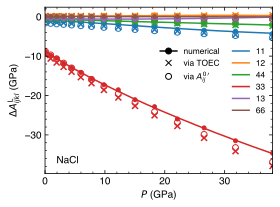

In [31]:
F = make_strain("e3", xi)
eta = to_eta(F)

for i in range(df3.shape[0]):
    
    # first method
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    cijk = numpy.copy(aijk)
    cijk -=       _3to6(numpy.einsum("ijkl,mn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("njkl,im->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("inkl,jm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijnl,km->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkn,lm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("mjkl,in->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("imkl,jn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijml,kn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkm,ln->ijklmn", _6to3(aij), numpy.eye(3)))
    
    daij = numpy.einsum("ijklmn,mn->ijkl", _6to3(cijk), to_eta(F))
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[3,3]], c=colors[2], marker="x")
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[2,2]], c=colors[3], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,2]], c=colors[4], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[5,5]], c=colors[5], marker="x")
    
    # pressure derivatives
    
    tij = numpy.einsum("ijkl,kl->ij", _6to3(cij), eta)
    
    p = -1/3 * numpy.sum(numpy.diag(tij))
    t = tij + p * numpy.eye(3)
    
    aij_p = c_ij(df5.iloc[i])
    
    daij = _6to3(aij_p * p)
    daij -= 1/4 * numpy.einsum("mjkl,im->ijkl", _6to3(aij_p), t)
    daij -= 1/4 * numpy.einsum("imkl,jm->ijkl", _6to3(aij_p), t)
    daij -= 1/4 * numpy.einsum("ijml,km->ijkl", _6to3(aij_p), t)
    daij -= 1/4 * numpy.einsum("ijkm,lm->ijkl", _6to3(aij_p), t)
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,0]], ec=colors[0], marker="o", c="none")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,1]], ec=colors[1], marker="o", c="none")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[3,3]], ec=colors[2], marker="o", c="none")
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[2,2]], ec=colors[3], marker="o", c="none")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[0,2]], ec=colors[4], marker="o", c="none")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(daij)[5,5]], ec=colors[5], marker="o", c="none")

###

tmp1 = pandas.read_table(f"data/{system}/elast-e33-x{xi}.dat", sep=r"\s+")
tmp1 = tmp1.sort_values(by="V")
if (xi == 0.01) and (system == "NaCl"):
    tmp1["V"] = _to_ang3(tmp1["V"].values)
tmp1.index = tmp1["V"]
tmp0 = df3_.apply(lambda row: flatten(c_ij(row), proto=row), axis=1)

display(tmp0)
display(tmp1)

for i, key in enumerate(["11", "12", "44", "33", "13", "66"]):
    p_array1 = _to_gpa(p_of_v(_from_ang3(tmp1["V"].values)))
    
    x_array0 = x_of_v(tmp0["volume"])
    x_array1 = x_of_v(tmp1["V"])
    
    p = numpy.polyfit(x_array0, tmp0[f"c{key}"], 3)
    c_array0 = numpy.polyval(p, x_array1)
    
    p = numpy.polyfit(x_array1, tmp1[f"c{key}"], 3)
    c_array1 = tmp1[f"c{key}"]
    
    plt.plot(
        p_array1,
        c_array1 - c_array0,
        markersize=4, marker="o", ls="", c=colors[i])

    p = numpy.polyfit(x_of_v(tmp0["volume"]), tmp0[f"c{key}"], 3)
    c_array0 = numpy.polyval(p, x_array)
    
    p = numpy.polyfit(x_of_v(tmp1["V"]), tmp1[f"c{key}"], 3)
    c_array1 = numpy.polyval(p, x_array)
    
    plt.plot(p_array, c_array1 - c_array0, c=colors[i])
    
###
    
plt.xlim(left=0, right=df3["pressure"].max())
# plt.ylim(bottom=0)
plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

leg1 = plt.legend([
    *[Line2D([], [], color=c) for c in colors[:6]],
], [
    "11", "12", "44", "33", "13", "66",
], loc="upper right", bbox_to_anchor=[1, .8], fontsize="small")

leg2 = plt.legend([
    Line2D([], [], color="k", ls="-", marker="o", markersize=6),
    Line2D([], [], color="k", ls="", marker="x", markersize=6),
    Line2D([], [], color="none", ls="", marker="o", markersize=6, mec="k"),
], [
    r"numerical",
    r"via TOEC",
    r"via $A^{0\,\prime}_{ij}$",
], loc="upper right", bbox_to_anchor=[.8, .8], fontsize="small")

plt.gca().add_artist(leg1)

plt.ylabel(r"$\Delta A_{ijkl}^\mathrm{L}$ (GPa)")
plt.xlabel("$P$ (GPa)")

plt.tight_layout()
plt.savefig(f"dSOECxP-e33-x{xi}-cijk-{system}.png", dpi=300)
plt.show()

P           V       c11       c22       c33      c12  \
V                                                                       
708.57512   379.97   708.57512  445.0380  445.3010  414.6300  21.0400   
735.56846   318.10   735.56846  389.4470  389.3370  361.5800  20.3326   
762.56180   265.62   762.56180  340.8640  340.9010  316.0530  19.6112   
789.55514   220.96   789.55514  298.6860  299.0350  275.8750  19.0733   
816.54847   182.87   816.54847  262.3670  262.6480  242.0840  18.5688   
843.54181   150.25   843.54181  230.2660  230.4510  211.6460  17.6066   
870.53515   122.29   870.53515  202.5620  202.5240  186.0140  16.9497   
897.52849    98.38   897.52849  178.3550  178.3110  162.6140  16.5903   
924.52183    77.58   924.52183  156.8660  156.4100  142.4870  15.6192   
951.51516    59.70   951.51516  137.8730  137.6580  125.0040  15.2513   
978.50850    44.32   978.50850  120.9960  120.9880  109.3800  14.7736   
1005.50184   30.97  1005.50184  106.2400  106.2180   95.5677  14.2875   
1032.49518   19.39  1032.49518   93.0377   93.2348   83.6680  13.9503   
1059.48851    9.38  1059.48851   81.5460   81.4031   72.6719  13.3079   
1086.48185    0.70  1086.48185   71.2440   71.1724   63.1340  13.0071   
1113.47519   -6.84  1113.47519   61.8324   61.9864   54.7088  12.6551   

                c13      c23      c44      c55      c66  
V                                                        
708.57512   20.6156  20.6156  47.8849  47.8936  49.9600  
735.56846   19.6440  19.6440  42.5784  42.5783  44.4316  
762.56180   19.1167  19.1167  38.0085  38.0084  39.6818  
789.55514   17.8601  17.8601  34.0634  34.0628  35.5793  
816.54847   17.7835  17.7835  30.6498  30.6475  32.0229  
843.54181   16.6682  16.6682  27.6749  27.6745  28.9355  
870.53515   16.5818  16.5818  25.0867  25.0862  26.2360  
897.52849   15.5114  15.5114  22.8234  22.8237  23.8669  
924.52183   14.9361  14.9361  20.8289  20.8295  21.7989  
951.51516   14.6051  14.6051  19.0781  19.0764  19.9662  
978.50850   14.0754  14.0754  17.5304  17.5303  18.3522  
1005.50184  13.5750  13.5750  16.1651  16.1650  16.9244  
1032.49518  13.4006  13.4006  14.9492  14.9482  15.6500  
1059.48851  12.8127  12.8127  13.8636  13.8638  14.5197  
1086.48185  12.4863  12.4863  12.8966  12.8967  13.5072  
1113.47519  12.2160  12.2160  12.0346  12.0348  12.6108

pressure  volume         c11        c12        c44         c111  \
105.0  38.002910   105.0  449.286120  20.684931  49.991648 -5138.603660   
109.0  31.813671   109.0  393.077137  20.037577  44.456026 -4593.249080   
113.0  26.566074   113.0  344.268286  19.376171  39.688511 -4109.058462   
117.0  22.101900   117.0  301.845531  18.715223  35.570280 -3679.962544   
121.0  18.292586   121.0  264.916782  18.064629  32.001664 -3299.896074   
125.0  15.033082   125.0  232.708482  17.430990  28.899253 -2963.136598   
129.0  12.237104   129.0  204.555694  16.818559  26.193294 -2664.458478   
133.0   9.833425   133.0  179.889796  16.229916  23.825409 -2399.183515   
137.0   7.762973   137.0  158.225898  15.666452  21.746674 -2163.175566   
141.0   5.976537   141.0  139.151012  15.128713  19.916000 -1952.806625   
145.0   4.432948   145.0  122.313443  14.616659  18.298801 -1764.910151   
149.0   3.097631   149.0  107.413493  14.129842  16.865883 -1596.730517   
153.0   1.941432   153.0   94.195473  13.667542  15.592535 -1445.873414   
157.0   0.939688   157.0   82.440897  13.228860  14.457782 -1310.259641   
161.0   0.071458   161.0   71.962726  12.812788  13.443763 -1188.083358   
165.0  -0.681093   165.0   62.600514  12.418263  12.535229 -1077.775079   

            c112       c123       c144        c166       c456  
105.0 -63.695405  59.750603  34.985884 -285.139675  13.221073  
109.0 -63.188790  54.927865  32.159699 -254.623859  14.185716  
113.0 -62.429833  51.009404  29.782266 -228.093484  14.883788  
117.0 -61.441287  47.730518  27.760982 -204.959099  15.372316  
121.0 -60.256601  44.912383  26.025875 -184.721765  15.696214  
125.0 -58.912059  42.433111  24.523378 -166.960559  15.890917  
129.0 -57.442669  40.208882  23.211971 -151.320804  15.984437  
133.0 -55.880184  38.181531  22.059100 -137.503584  15.998961  
137.0 -54.252331  36.310295  21.038962 -125.256690  15.952095  
141.0 -52.582701  34.566294  20.130898 -114.366934  15.857832  
145.0 -50.890975  32.928806  19.318205 -104.653712  15.727312  
149.0 -49.193309  31.382741  18.587261  -95.963634  15.569406  
153.0 -47.502775  29.916918  17.926859  -88.166068  15.391186  
157.0 -45.829797  28.522881  17.327710  -81.149444  15.198292  
161.0 -44.182564  27.194089  16.782054  -74.818198  14.995214  
165.0 -42.567391  25.925348  16.283364  -69.090233  14.785525

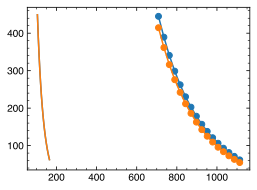

In [32]:
tmp = pandas.read_table(f"data/{system}/elast-e33-x{xi}.dat", sep=r"\s+")
tmp = tmp.sort_values(by="V")
tmp.index = tmp["V"]

for idx, col in tmp.iteritems():
    if max(abs(col.values)) < 1:
        tmp = tmp.drop(idx, axis=1)
    
display(tmp)
display(df3_)

for key in ["11", "33"]:
    line, = plt.plot(tmp["V"], tmp[f"c{key}"], marker="o")
    plt.plot(df3_["volume"], df3_[f"c11"], color=line.get_color())
    
# plt.ylim(100,200)

In [33]:
(161.0 / 0.529177 ** 3) ** (1/3) * numpy.eye(3) @ make_strain("e3", 0.005) @ make_strain("e3", -.005)

array([[10.28034443,  0.        ,  0.        ],
       [ 0.        , 10.28034443,  0.        ],
       [ 0.        ,  0.        , 10.2798304 ]])

If we have $B_0'^{IJKLMN}$ defined by

$$
C^{IJKLMN} = \frac{\partial \Xi_{IJKL}}{\partial E_{MN}}
$$

we will have
$$ \begin{split}
\Xi'^{IJKL}
    =& C^{IJKLMN} \cdot \frac{\partial E_{MN}}{\partial \ln V} \\
    =& C^{IJKLMN} \cdot \delta_{MN}
\end{split}$$

In [34]:
for key in ["11", "12", "44"]:
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(numpy.log(v_array)))
    
#     p = numpy.polyfit(x_of_v(df4["volume"]), df4[f"c{key}"], 3)
#     c_array = numpy.polyval(p, x_array)
#     line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(p_array), color=line.get_color(), ls="dotted")
    
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    cijk = numpy.copy(aijk)
    cijk -=       _3to6(numpy.einsum("ijkl,mn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("njkl,im->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("inkl,jm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijnl,km->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkn,lm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("mjkl,in->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("imkl,jn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijml,kn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkm,ln->ijklmn", _6to3(aij), numpy.eye(3)))
    
    aij_v = numpy.einsum("ijklmn,mn->ijkl", _6to3(cijk), numpy.eye(3)) / 3
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_v)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_v)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_v)[3,3]], c=colors[2], marker="x")
    
    aij_v = numpy.einsum("ijklmn,mn->ijkl", _6to3(aijk), numpy.eye(3)) / 3
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_v)[0,0]], c=colors[0], marker="+")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_v)[0,1]], c=colors[1], marker="+")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_v)[3,3]], c=colors[2], marker="+")
        
    
    
plt.ylabel(r"$\partial A_{ijkl} / \partial \log V$")
plt.xlabel("$P$ (GPa)")

plt.xlim(left=0, right=df3["pressure"].max())
# plt.ylim(bottom=0)
plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:3]],
    Line2D([], [], color="k", ls="-",      marker="", markersize=4),
#     Line2D([], [], color="k", ls="dotted", marker="", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=4),
    Line2D([], [], color="k", ls="", marker="+", markersize=4),
], [
    "11", "22", "44",
    "$\partial A_{ijkl} / \partial \log V$",
    r"via $C_{ijklmn}$",
    r"via $A_{ijklmn}$",

], loc="center right", bbox_to_anchor=[1, .6], fontsize="small")

plt.tight_layout()

# plt.savefig(f"dSOECdPxP-{system}.png", dpi=300)
plt.show()

But
$$ \frac{\partial \Xi^{IJKL}}{\partial \ln V} = B_0^{IJKLMN} \cdot \delta_{MN} $$
does not necessarily mean
$$
\begin{aligned}
B_{0}^{IJKLMN} = \frac{1}{8} (\delta^{IN} & \Xi^{\prime M J K L}+\delta^{I M} \Xi^{\prime N J K L}+\delta^{J N} \Xi^{\prime I M K L} \\
&+\delta^{J M} \Xi^{\prime I N K L}+\delta^{K N} \Xi^{\prime J J M L}+\delta^{K M} \Xi^{\prime I J N L} \\
&+\delta^{L N} \Xi^{\prime I J K M}+\delta^{L M} \Xi^{\prime J J K N})
\end{aligned}
$$

In [35]:
for key in ["111", "112", "123", "144", "166", "456"]:
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, c_array)
    plt.scatter(df3["pressure"], df3[f"c{key}"], s=10)
    
#     p = numpy.polyfit(x_of_v(df4["volume"]), df4[f"c{key}"], 3)
#     c_array = numpy.polyval(p, x_array)
#     line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(p_array), color=line.get_color(), ls="dotted")

tmp = df4_.copy()

from scipy.interpolate import InterpolatedUnivariateSpline

for name, col in tmp.iteritems():
    if not name.startswith("c"): continue
    p = numpy.polyfit(x_of_v(df4_["volume"]), col, 3)
    c_array = numpy.polyval(p, x_array)
    der = numpy.gradient(c_array) / numpy.gradient(numpy.log(v_array))
    tmp[name] = InterpolatedUnivariateSpline(v_array, der)(df4_["volume"])
    
# display(tmp)


for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    
    cijk = numpy.copy(aijk)
    cijk -=       _3to6(numpy.einsum("ijkl,mn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("njkl,im->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("inkl,jm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijnl,km->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkn,lm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("mjkl,in->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("imkl,jn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijml,kn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkm,ln->ijklmn", _6to3(aij), numpy.eye(3)))
    
    for m, (j,k,l) in enumerate(["111", "112", "123", "144", "166", "456"]):
        j = int(j) - 1
        k = int(k) - 1
        l = int(l) - 1
        plt.scatter([df3.iloc[i]["pressure"]], [cijk[j,k,l]], c=colors[m], marker="x")
        
    daij_dlnv = _6to3(c_ij(tmp.iloc[i]))
    b0 = numpy.zeros((3,3,3,3,3,3))
    
    
    b0 += 1/8 * numpy.einsum("in,mjkl->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("im,njkl->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("jn,imkl->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("jm,inkl->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("kn,ijml->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("km,ijnl->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("ln,ijkm->ijklmn", numpy.eye(3), daij_dlnv)
    b0 += 1/8 * numpy.einsum("lm,ijkn->ijklmn", numpy.eye(3), daij_dlnv)
    
    b0 = _3to6(b0) * 3
    
    for m, (j,k,l) in enumerate(["111", "112", "123", "144", "166", "456"]):
        j = int(j) - 1
        k = int(k) - 1
        l = int(l) - 1
        plt.scatter([df3.iloc[i]["pressure"]], [b0[j,k,l]], c=colors[m], marker="^")
    
    
plt.ylabel(r"$A_{ijklmn}$")
plt.xlabel("$P$ (GPa)")

plt.xlim(left=0, right=df3["pressure"].max())
# plt.ylim(bottom=0)
plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:6]],
    Line2D([], [], color="k", ls="-", marker="o", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=4),
    Line2D([], [], color="k", ls="", marker="^", markersize=4),
], [
    "111", "112", "123", "144", "166", "456",
    "$A_{ijk}$",
    "$C_{ijk}$",
     r"Eq. (2.214)"
], loc="center right", bbox_to_anchor=[1, .6], fontsize="small", ncol=2)

plt.tight_layout()

# plt.savefig(f"dSOECdPxP-{system}.png", dpi=300)
plt.show()


$$
\frac{\partial A_{ijkl}}{\partial P} = \frac{\partial A_{ijkl}}{\partial \eta_{mn}} \frac{\partial \eta_{mn}}{\partial P} 
= - C_{ijklmn} (C^{-1})_{mnpq} \delta_{pq} .
$$

$$
\frac{\partial A_{ijkl}}{\partial P} = - A_{ijklmn} (C^{-1})_{mnpq} \delta_{pq} - \frac{1}{3} A_{ijkl} (C^{-1})_{mnpq} \delta_{mn} \delta_{pq} .
$$

In [36]:
for key in ["11", "12", "44"]:
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(p_array))
    
#     p = numpy.polyfit(x_of_v(df4["volume"]), df4[f"c{key}"], 3)
#     c_array = numpy.polyval(p, x_array)
#     line, = plt.plot(p_array, numpy.gradient(c_array) / numpy.gradient(p_array), color=line.get_color(), ls="dotted")
    
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cij = c_ij(df4_.iloc[i])
    cijk = numpy.copy(aijk)
    
    cijk -=       _3to6(numpy.einsum("ijkl,mn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("njkl,im->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("inkl,jm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijnl,km->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkn,lm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("mjkl,in->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("imkl,jn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijml,kn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkm,ln->ijklmn", _6to3(aij), numpy.eye(3)))
    
    
    aij_p = \
        - numpy.einsum("ijklmn,mnpq,pq->ijkl", _6to3(aijk),  _6to3(numpy.linalg.inv(cij)), numpy.eye(3)) \
        - 1/3 * numpy.einsum("ijkl,mnpq,mn,pq->ijkl", _6to3(aij), _6to3(numpy.linalg.inv(cij)), numpy.eye(3), numpy.eye(3))
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[0,0]], c=colors[0], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[0,1]], c=colors[1], marker="x")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[3,3]], c=colors[2], marker="x")
        
    aij_p = \
        - numpy.einsum("ijklmn,mnpq,pq->ijkl", _6to3(cijk),  _6to3(numpy.linalg.inv(cij)), numpy.eye(3)) \
    
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[0,0]], c=colors[0], marker="+")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[0,1]], c=colors[1], marker="+")
    plt.scatter([df3.iloc[i]["pressure"]], [_3to6(aij_p)[3,3]], c=colors[2], marker="+")
        
    
plt.ylabel(r"$\partial A_{ij} / \partial P$")
plt.xlabel("$P$ (GPa)")

plt.xlim(left=0, right=df3["pressure"].max())
plt.ylim(bottom=0)
plt.text(0.95, 0.95, system, ha='right', va='top', transform=plt.gca().transAxes)

plt.legend([
    *[Line2D([], [], color=c) for c in colors[:3]],
    Line2D([], [], color="k", ls="-",      marker="", markersize=4),
#     Line2D([], [], color="k", ls="dotted", marker="", markersize=4),
    Line2D([], [], color="k", ls="", marker="x", markersize=4),
    Line2D([], [], color="k", ls="", marker="+", markersize=4),
], [
    "11", "22", "44",
    "$A_{ij}'$ (numerical)",
#     "$C_{ij}'$"
    r"$A_{ij}'$ (via $A_{ijk}$)",
    r"$A_{ij}'$ (via $C_{ijk}$)"
], loc="center right", bbox_to_anchor=[1, .4], fontsize="small")

plt.tight_layout()

# plt.savefig(f"dSOECdPxP-{system}.png", dpi=300)
plt.show()

In [37]:
for key in ["111", "112", "123", "144", "166", "456"]:
    
    line, = plt.plot(df3["pressure"], df3[f"c{key}"] / 1e3, label=key[1:], marker="o", markersize=4, ls="")
    
    p = numpy.polyfit(x_of_v(df3["volume"]), df3[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, c_array / 1e3, color=line.get_color())
    
tmp = []
    
for i in range(df3.shape[0]):
    
    aij = c_ij(df3_.iloc[i])
    aijk = c_ijk(df3_.iloc[i])
    cijk = numpy.copy(aijk)
    
    cijk -=       _3to6(numpy.einsum("ijkl,mn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("njkl,im->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("inkl,jm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijnl,km->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkn,lm->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("mjkl,in->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("imkl,jn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijml,kn->ijklmn", _6to3(aij), numpy.eye(3)))
    cijk += 1/2 * _3to6(numpy.einsum("ijkm,ln->ijklmn", _6to3(aij), numpy.eye(3)))
    
    tmp.append(flatten(cijk, ndim=3))
    
tmp = pandas.DataFrame(tmp)

display(tmp)

for i, key in enumerate(["111", "112", "123", "144", "166", "456"]):
    
    line, = plt.plot(df3["pressure"], tmp[f"c{key}"] / 1e3, label=key[1:], marker="^", markersize=4, ls="", c=colors[i])
    
    p = numpy.polyfit(x_of_v(df3["volume"]), tmp[f"c{key}"], 3)
    c_array = numpy.polyval(p, x_array)
    line, = plt.plot(p_array, c_array / 1e3, color=line.get_color(), ls="dotted")

plt.xlabel("$P$ (GPa)")
plt.ylabel(r"$A_{ijk}$, $C_{ijk}$ (×10$^3$ GPa)")

plt.text(0.05, 0.05, system, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.xlim(left=0, right=df3["pressure"].max())
# plt.legend(bbox_to_anchor=[1, .85], loc="upper right")

leg1 = plt.legend([
    *[Line2D([], [], color=c) for c in colors],
], ["111", "112", "123", "144", "166", "456"], loc="upper right", bbox_to_anchor=[1, .90])

leg2 = plt.legend([
    Line2D([], [], color="k", ls="-",      marker="o", markersize=4),
    Line2D([], [], color="k", ls="dotted", marker="^", markersize=4),
], ["$A_{ijk}$", "$C_{ijk}$"], loc="upper right", bbox_to_anchor=[.75, .85])

plt.gca().add_artist(leg1)

plt.tight_layout()
# plt.savefig(f"TOECxP-{system}.png", dpi=300)

plt.show()

c111       c112       c113  c114  c115  c116        c122  \
0  -3790.745299 -43.010475 -43.010475   0.0   0.0   0.0 -512.981526   
1  -3414.017670 -43.151213 -43.151213   0.0   0.0   0.0 -456.265927   
2  -3076.253604 -43.053662 -43.053662   0.0   0.0   0.0 -406.698119   
3  -2774.425951 -42.726063 -42.726063   0.0   0.0   0.0 -363.286818   
4  -2505.145727 -42.191971 -42.191971   0.0   0.0   0.0 -325.173383   
5  -2265.011153 -41.481069 -41.481069   0.0   0.0   0.0 -291.620541   
6  -2050.791397 -40.624110 -40.624110   0.0   0.0   0.0 -261.998363   
7  -1859.514126 -39.650267 -39.650267   0.0   0.0   0.0 -235.769980   
8  -1688.497873 -38.585879 -38.585879   0.0   0.0   0.0 -212.478228   
9  -1535.353589 -37.453988 -37.453988   0.0   0.0   0.0 -191.733713   
10 -1397.969823 -36.274316 -36.274316   0.0   0.0   0.0 -173.204418   
11 -1274.490039 -35.063467 -35.063467   0.0   0.0   0.0 -156.606802   
12 -1163.286996 -33.835233 -33.835233   0.0   0.0   0.0 -141.698247   
13 -1062.936950 -32.600938 -32.600938   0.0   0.0   0.0 -128.270695   
14  -972.195178 -31.369776 -31.369776   0.0   0.0   0.0 -116.145291   
15  -889.973538 -30.149128 -30.149128   0.0   0.0   0.0 -105.167905   

         c123  c124  c125  ...  c444  c445  c446  c455       c456  c466  c555  \
0   39.065673   0.0   0.0  ...   0.0   0.0   0.0   0.0  63.212721   0.0   0.0   
1   34.890287   0.0   0.0  ...   0.0   0.0   0.0   0.0  58.641743   0.0   0.0   
2   31.633233   0.0   0.0  ...   0.0   0.0   0.0   0.0  54.572298   0.0   0.0   
3   29.015295   0.0   0.0  ...   0.0   0.0   0.0   0.0  50.942596   0.0   0.0   
4   26.847754   0.0   0.0  ...   0.0   0.0   0.0   0.0  47.697878   0.0   0.0   
5   25.002121   0.0   0.0  ...   0.0   0.0   0.0   0.0  44.790171   0.0   0.0   
6   23.390323   0.0   0.0  ...   0.0   0.0   0.0   0.0  42.177731   0.0   0.0   
7   21.951614   0.0   0.0  ...   0.0   0.0   0.0   0.0  39.824370   0.0   0.0   
8   20.643844   0.0   0.0  ...   0.0   0.0   0.0   0.0  37.698768   0.0   0.0   
9   19.437582   0.0   0.0  ...   0.0   0.0   0.0   0.0  35.773833   0.0   0.0   
10  18.312148   0.0   0.0  ...   0.0   0.0   0.0   0.0  34.026113   0.0   0.0   
11  17.252899   0.0   0.0  ...   0.0   0.0   0.0   0.0  32.435289   0.0   0.0   
12  16.249376   0.0   0.0  ...   0.0   0.0   0.0   0.0  30.983722   0.0   0.0   
13  15.294022   0.0   0.0  ...   0.0   0.0   0.0   0.0  29.656074   0.0   0.0   
14  14.381300   0.0   0.0  ...   0.0   0.0   0.0   0.0  28.438977   0.0   0.0   
15  13.507084   0.0   0.0  ...   0.0   0.0   0.0   0.0  27.320754   0.0   0.0   

    c556  c566  c666  
0    0.0   0.0   0.0  
1    0.0   0.0   0.0  
2    0.0   0.0   0.0  
3    0.0   0.0   0.0  
4    0.0   0.0   0.0  
5    0.0   0.0   0.0  
6    0.0   0.0   0.0  
7    0.0   0.0   0.0  
8    0.0   0.0   0.0  
9    0.0   0.0   0.0  
10   0.0   0.0   0.0  
11   0.0   0.0   0.0  
12   0.0   0.0   0.0  
13   0.0   0.0   0.0  
14   0.0   0.0   0.0  
15   0.0   0.0   0.0  

[16 rows x 56 columns]

In [38]:
df3

pressure  volume         c11        c12        c44         c111  \
105.0  38.002910   105.0  449.357277  20.685497  49.996407 -5138.270566   
109.0  31.813671   109.0  393.001706  20.030232  44.452128 -4593.064394   
113.0  26.566074   113.0  344.196951  19.379601  39.681022 -4108.962946   
117.0  22.101900   117.0  301.814192  18.731557  35.572485 -3682.804303   
121.0  18.292586   121.0  264.935667  18.061123  31.997208 -3299.834332   
125.0  15.033082   125.0  232.785576  17.428174  28.902661 -2961.719915   
129.0  12.237104   129.0  204.631914  16.810935  26.203901 -2664.288441   
133.0   9.833425   133.0  179.947166  16.221518  23.830051 -2395.674262   
137.0   7.762973   137.0  158.265548  15.659700  21.751905 -2161.308971   
141.0   5.976537   141.0  139.095388  15.136562  19.913688 -1955.701090   
145.0   4.432948   145.0  122.263161  14.619092  18.288238 -1768.953893   
149.0   3.097631   149.0  107.349402  14.132402  16.861295 -1594.671727   
153.0   1.941432   153.0   94.119270  13.674502  15.587885 -1446.124475   
157.0   0.939688   157.0   82.390392  13.239323  14.455297 -1312.088778   
161.0   0.071458   161.0   71.991564  12.807173  13.444981 -1186.969837   
165.0  -0.681093   165.0   62.706107  12.409723  12.543604 -1076.724833   

            c112       c123       c144        c166       c456  
105.0 -64.012125  59.975324  34.889492 -285.171133  13.191688  
109.0 -62.774102  54.441257  32.220336 -254.707308  14.235278  
113.0 -62.695444  51.978274  30.008076 -228.007790  14.870073  
117.0 -60.552010  46.578469  27.688312 -204.686495  15.396772  
121.0 -60.051580  44.037825  26.022351 -184.658609  15.700986  
125.0 -59.583178  43.113031  24.463012 -167.123548  15.864627  
129.0 -57.735637  40.837402  23.000376 -151.380025  15.959445  
133.0 -56.909784  39.153931  22.080996 -137.949316  15.991649  
137.0 -54.806199  37.126780  20.773317 -125.523875  15.911477  
141.0 -51.963072  34.355750  20.398727 -114.018147  15.889535  
145.0 -49.276808  30.484805  19.627203 -104.191217  15.712203  
149.0 -49.579498  31.698368  18.490714  -96.111076  15.595191  
153.0 -47.491773  30.473887  17.809415  -88.255544  15.434826  
157.0 -45.124746  27.383393  17.548512  -80.800294  15.234423  
161.0 -44.755833  28.207458  16.736425  -74.843789  14.996965  
165.0 -42.936880  26.055713  16.147203  -69.359575  14.725148